# Using Online Job Postings to Improve your Data Science Resume

We’re ready to expand our data science career. Six months from now, we’ll apply for a new job. In preparation, we begin to draft our resume. The early draft is rough and incomplete. It doesn’t yet cover our career goals or education.

Our resume draft is far from perfect. It’s possible that certain vital data science skills are not yet represented. If so, what are those missing skills? We decide to find out analytically. After all, we are data scientists! We fill in gaps in knowledge using rigorous analysis, so why shouldn’t we apply that rigorous analysis to ourselves?

First we need some data. We go online and visit a popular job-search site. The website offers millions of searchable job listings, posted by understaffed employers. A built-in search engine allows us to filter the jobs by keyword, such as *analyst* or *data scientist*. Additionally, the search engine can match jobs to uploaded documents. This feature is intended to search postings based on resume content. Unfortunately, our resume is still a work in progress. So instead, we search on the table of contents of a book! We copy and paste the first 15 listed sections of the table of contents into a text file.

Next, we upload the file to the job-search site. Material is compared against millions of job listings, and thousands of job postings are returned. Some of these postings may be more relevant than others; we can’t vouch for the search engine’s overall quality, but the data is appreciated. We download the HTML from every posting.

Our goal is to extract common data science skills from the downloaded data. We’ll then compare these skills to our resume to determine which skills are missing. To reach our goal, we’ll proceed like this:

1. Parse out all the text from the downloaded HTML files.
2. Explore the parsed output to learn how job skills are commonly described in online postings. Perhaps specific HTML tags are more commonly used to underscore job skills.
3. Try to filter out any irrelevant job postings from our dataset. The search engine isn’t perfect. Perhaps some irrelevant postings were erroneously downloaded. We can evaluate relevance by comparing the postings with our resume and the table of contents.
4. Cluster the job skills within the relevant postings, and visualize the clusters.
5. Compare the clustered skills to our resume content. We’ll then make plans to update our resume with any missing data science skills.

<aside>
📌 To address the problem at hand, we need to know how to do the following: 1) Measure similarity between texts. 2) Efficiently cluster large text datasets. 3) Visually display multiple text clusters. 4) Parse HTML files for text content.

</aside>

Our rough draft of the resume is stored in the file resume.txt. The full text of that draft is as follows:

```
Experience
1. Developed probability simulations using NumPy
2. Assessed online ad clicks for statistical significance using permutation testing
3. Analyzed disease outbreaks using common clustering algorithms
Additional Skills
1. Data visualization using Matplotlib
2. Statistical analysis using SciPy
3. Processing structured tables using Pandas
4. Executing K-means clustering and DBSCAN clustering using scikit-learn
5. Extracting locations from text using GeoNamesCache
6. Location analysis and visualization using GeoNamesCache and Cartopy
7. Dimensionality reduction with PCA and SVD using scikit-learn
8. NLP analysis and text topic detection using scikit-learn
```

Our preliminary draft is short and incomplete. To compensate for any missing material, we also use the partial table of contents of the book, which is stored in the file table_of_contents.txt. It covers the first 15 sections of the book, as well as all the top-level subsection headers. The table of contents file has been utilized to search for thousands of relevant job postings that were downloaded and stored in a job_postings directory. Each file in the directory is an HTML file associated with an individual posting. These files can be viewed locally in a web browser.

In [ ]:
%%sh
wget -q --show-progress https://github.com/sparsh-ai/general-recsys/raw/T426474/bookcamp_code.zip
unzip bookcamp_code.zip
unzip bookcamp_code/Case_Study4.zip
unzip Case_Study4/job_postings.zip 
mv Case_Study4/resume.txt .
mv Case_Study4/table_of_contents.txt .

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import glob
html_contents = []

for file_name in sorted(glob.glob('job_postings/*.html')):
    try:
        with open(file_name, 'r') as f:
            html_contents.append(f.read())
    except:
        None
            
print(f"We've loaded {len(html_contents)} HTML files.")

We've loaded 1458 HTML files.


In [ ]:
from bs4 import BeautifulSoup as bs

soup_objects = []
for html in html_contents:
    soup = bs(html)
    assert soup.title is not None
    assert soup.body is not None
    soup_objects.append(soup)

In [ ]:
import pandas as pd
html_dict = {'Title': [], 'Body': []}

for soup in soup_objects:
    title = soup.find('title').text
    body = soup.find('body').text
    html_dict['Title'].append(title)
    html_dict['Body'].append(body)

df_jobs = pd.DataFrame(html_dict)
summary = df_jobs.describe()
summary

Title                                               Body
count                            1458                                               1458
unique                           1364                                               1458
top     Data Scientist - New York, NY  Leadership Partner, Data and Analytics - West ...
freq                               13                                                  1

In [ ]:
from IPython.core.display import display, HTML
assert len(set(html_contents)) == len(html_contents)
display(HTML(html_contents[0]))

In [ ]:
df_jobs['Bullets'] = [[bullet.text.strip()
                      for bullet in soup.find_all('li')]
                      for soup in soup_objects]

In [ ]:
bulleted_post_count = 0
for bullet_list in df_jobs.Bullets:
    if bullet_list:
        bulleted_post_count += 1

percent_bulleted = 100 * bulleted_post_count / df_jobs.shape[0]
print(f"{percent_bulleted:.2f}% of the postings contain bullets")

90.53% of the postings contain bullets


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

def rank_words(text_list):
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(text_list).toarray()
    df = pd.DataFrame({'Words': vectorizer.get_feature_names(),
                       'Summed TFIDF': tfidf_matrix.sum(axis=0)})
    sorted_df = df.sort_values('Summed TFIDF', ascending=False)
    return sorted_df

all_bullets = []
for bullet_list in df_jobs.Bullets:
    all_bullets.extend(bullet_list)

sorted_df = rank_words(all_bullets)
print(sorted_df[:5].to_string(index=False))

      Words  Summed TFIDF
 experience    878.030398
       data    842.978780
     skills    440.780236
       work    371.684232
    ability    370.969638


In [ ]:
non_bullets = []
for soup in soup_objects:
    body = soup.body
    for tag in body.find_all('li'):
        tag.decompose()

    non_bullets.append(body.text)

sorted_df = rank_words(non_bullets)
print(sorted_df[:5].to_string(index=False))

      Words  Summed TFIDF
       data     99.111312
       team     39.175041
       work     38.928948
 experience     36.820836
   business     36.140488


In [ ]:
regex = r'Data Scien(ce|tist)'
df_non_ds_jobs = df_jobs[~df_jobs.Title.str.contains(regex, case=False)]

percent_non_ds = 100 * df_non_ds_jobs.shape[0] / df_jobs.shape[0]
print(f"{percent_non_ds:.2f}% of the job posting titles do not mention a "
       "data science position. Below is a sample of such titles:\n")

for title in df_non_ds_jobs.Title[:10]:
    print(title)

64.33% of the job posting titles do not mention a data science position. Below is a sample of such titles:

Patient Care Assistant / PCA - Med/Surg (Fayette, AL) - Fayette, AL
Data Manager / Analyst - Oakland, CA
Scientific Programmer - Berkeley, CA
JD Digits - AI Lab Research Intern - Mountain View, CA
Operations and Technology Summer 2020 Internship-West Coast - Universal City, CA
Data and Reporting Analyst - Olympia, WA 98501
Senior Manager Advanced Analytics - Walmart Media Group - San Bruno, CA
Data Specialist, Product Support Operations - Sunnyvale, CA
Deep Learning Engineer - Westlake, TX
Research Intern, 2020 - San Francisco, CA 94105


In [ ]:
resume = open('resume.txt', 'r').read()
table_of_contents = open('table_of_contents.txt', 'r').read()
existing_skills = resume + table_of_contents

In [ ]:
text_list = df_jobs.Body.values.tolist() + [existing_skills]
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(text_list).toarray()
cosine_similarities = tfidf_matrix[:-1] @ tfidf_matrix[-1]

In [ ]:
df_jobs['Relevance'] = cosine_similarities
sorted_df_jobs = df_jobs.sort_values('Relevance', ascending=False)
for title in sorted_df_jobs[-20:].Title:
    print(title)

Data Analyst Internship (8 month minimum) - San Francisco, CA
Leadership and Advocacy Coordinator - Oakland, CA 94607
Finance Consultant - Audi Palo Alto - Palo Alto, CA
RN - Hattiesburg, MS
Configuration Management Specialist - Dahlgren, VA
Deal Desk Analyst - Mountain View, CA
Dev Ops Engineer AWS - Rockville, MD
Web Development Teaching Assistant - UC Berkeley (Berkeley) - Berkeley, CA
Scorekeeper - Oakland, CA 94612
Direct Care - All Experience Levels (CNA, HHA, PCA Welcome) - Norwell, MA 02061
Director of Marketing - Cambridge, MA
Certified Strength and Conditioning Specialist - United States
PCA - PCU Full Time - Festus, MO 63028
Performance Improvement Consultant - Los Angeles, CA
Patient Services Rep II - Oakland, CA
Lab Researcher I - Richmond, CA
Part-time instructor of Statistics for Data Science and Machine Learning - San Francisco, CA 94105
Plant Engineering Specialist - San Pablo, CA
Page Not Found - Indeed Mobile
Director of Econometric Modeling - External Careers


In [ ]:
for title in sorted_df_jobs[:20].Title:
    print(title)

Chief Data Officer - Culver City, CA 90230
Data Scientist - Beavercreek, OH
Data Scientist Population Health - Los Angeles, CA 90059
Data Scientist - San Diego, CA
Data Scientist - Beavercreek, OH
Senior Data Scientist - New York, NY 10018
Data Architect - Raleigh, NC 27609
Data Scientist (PhD) - Spring, TX
Data Science Analyst - Chicago, IL 60612
Associate Data Scientist (BS / MS) - Spring, TX
Data Scientist - Streetsboro, OH 44241
Data Scientist - Los Angeles, CA
Sr Director of Data Science - Elkridge, MD
2019-57 Sr. Data Scientist - Reston, VA 20191
Data Scientist (PhD) - Intern - Spring, TX
Sr Data Scientist. - Alpharetta, GA 30004
Data Scientist GS 13/14 - Clarksburg, WV 26301
Data Science Intern (BS / MS) - Intern - Spring, TX
Senior Data Scientist - New York, NY 10038
Data Scientist - United States


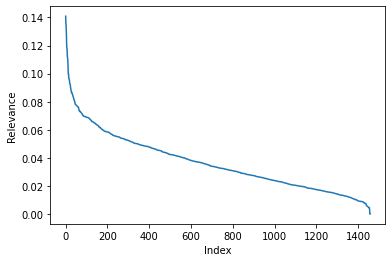

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(df_jobs.shape[0]), sorted_df_jobs.Relevance.values)
plt.xlabel('Index')
plt.ylabel('Relevance')
plt.show()

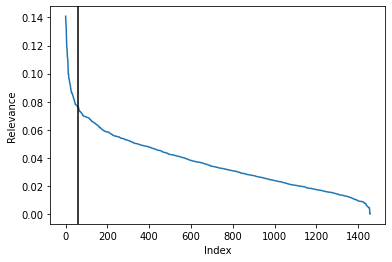

In [ ]:
plt.plot(range(df_jobs.shape[0]), sorted_df_jobs.Relevance.values)
plt.xlabel('Index')
plt.ylabel('Relevance')
plt.axvline(60, c='k')
plt.show()

In [ ]:
for title in sorted_df_jobs[40: 60].Title.values:
    print(title)

Data Scientist III - Pasadena, CA 91101
Global Data Engineer - Boston, MA
Data Analyst and Data Scientist - Summit, NJ
Data Scientist - Generalist - Glendale, CA
Data Scientist - Seattle, WA
IT Data Scientist - Contract - Riverton, UT
Data Scientist (Analytic Consultant 4) - San Francisco, CA
Data Scientist - Seattle, WA
Data Science & Tagging Analyst - Bethesda, MD 20814
Data Scientist - New York, NY
Senior Data Scientist - Los Angeles, CA
Principal Statistician - Los Angeles, CA
Senior Data Analyst - Los Angeles, CA
Data Scientist - Aliso Viejo, CA 92656
Data Engineer - Seattle, WA
Data Scientist - Digital Factory - Tampa, FL 33607
Data Scientist - Grapevine, TX 76051
Data Scientist - Bioinformatics - Denver, CO 80221
EPIDEMIOLOGIST - Los Angeles, CA
Data Scientist - Bellevue, WA


In [ ]:
for title in sorted_df_jobs[60: 80].Title.values:
    print(title)

Data Scientist - Aliso Viejo, CA
Data Scientist and Visualization Specialist - Santa Clara Valley, CA 95014
Data Scientist - Los Angeles, CA
Data Scientist Manager - NEW YORK LOCATION! - New York, NY 10036
Data Science Intern - San Francisco, CA 94105
Research Data Analyst - San Francisco, CA
Sr Data Scientist (Analytic Consultant 5) - San Francisco, CA
Data Scientist, Media Manipulation - Cambridge, MA
Manager, Data Science, Programming and Visualization - Boston, MA
Data Scientist in Broomfield, CO - Broomfield, CO
Senior Data Scientist - Executive Projects and New Solutions - Foster City, CA
Manager of Data Science - Burbank California - Burbank, CA
Data Scientist Manager - Hiring in Burbank! - Burbank, CA
Data Scientists needed in NY - Senior Consultants and Managers! - New York, NY 10036
Data Scientist - Menlo Park, CA
Data Engineer - Santa Clara, CA
Data Scientist - Remote
Data Scientist I-III - Phoenix, AZ 85021
SWE Data Scientist - Santa Clara Valley, CA 95014
Health Science Sp

In [ ]:
import re
def percent_relevant_titles(df):
    regex_relevant = re.compile(r'Data (Scien|Analy)',
                                flags=re.IGNORECASE)
    regex_irrelevant = re.compile(r'\b(Manage)',
                                  flags=re.IGNORECASE)
    match_count = len([title for title in df.Title
                       if regex_relevant.search(title)
                       and not regex_irrelevant.search(title)])
    percent = 100 * match_count / df.shape[0]
    return percent

percent = percent_relevant_titles(sorted_df_jobs[60: 80])
print(f"Approximately {percent:.2f}% of job titles between indices "
       "60 - 80 are relevant")

Approximately 65.00% of job titles between indices 60 - 80 are relevant


In [ ]:
percent = percent_relevant_titles(sorted_df_jobs[80: 100])
print(f"Approximately {percent:.2f}% of job titles between indices "
       "80 - 100 are relevant")

Approximately 80.00% of job titles between indices 80 - 100 are relevant


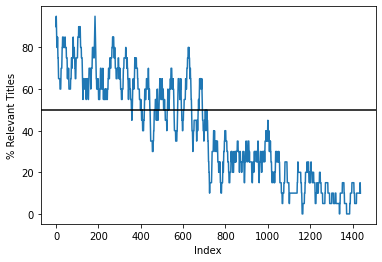

In [ ]:
def relevant_title_plot(index_range=20):
    percentages = []
    start_indices = range(df_jobs.shape[0] - index_range)
    for i in start_indices:
        df_slice = sorted_df_jobs[i: i + index_range]
        percent = percent_relevant_titles(df_slice)
        percentages.append(percent)

    plt.plot(start_indices, percentages)
    plt.axhline(50, c='k')
    plt.xlabel('Index')
    plt.ylabel('% Relevant Titles')

relevant_title_plot()
plt.show()

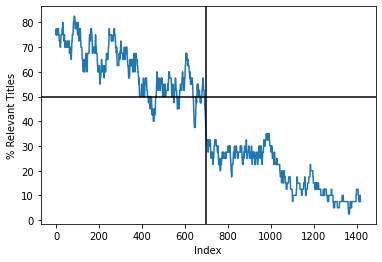

In [ ]:
relevant_title_plot(index_range=40)
plt.axvline(700, c='k')
plt.show()

In [ ]:
total_bullets = []
for bullets in sorted_df_jobs[:60].Bullets:
    total_bullets.extend(bullets)
df_bullets = pd.DataFrame({'Bullet': total_bullets})
print(df_bullets.describe())

                                                   Bullet
count                                                1091
unique                                                900
top     Knowledge of advanced statistical techniques a...
freq                                                    9


In [ ]:
total_bullets = sorted(set(total_bullets))
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(total_bullets)
num_rows, num_columns = tfidf_matrix.shape
print(f"Our matrix has {num_rows} rows and {num_columns} columns")

Our matrix has 900 rows and 2070 columns


In [ ]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
np.random.seed(0)

def shrink_matrix(tfidf_matrix):
    svd_object = TruncatedSVD(n_components=100)
    shrunk_matrix = svd_object.fit_transform(tfidf_matrix)
    return normalize(shrunk_matrix)

shrunk_norm_matrix = shrink_matrix(tfidf_matrix)

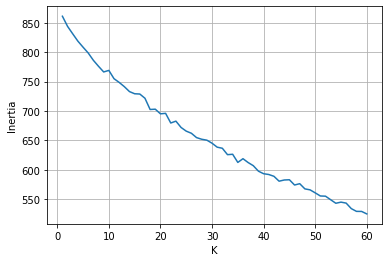

In [ ]:
np.random.seed(0)
from sklearn.cluster import MiniBatchKMeans
def generate_elbow_plot(matrix):
    k_values = range(1, 61)
    inertia_values = [MiniBatchKMeans(k).fit(matrix).inertia_
                      for k in k_values]
    plt.plot(k_values, inertia_values)
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

generate_elbow_plot(shrunk_norm_matrix)

In [ ]:
np.random.seed(0)
from sklearn.cluster import KMeans

def compute_cluster_groups(shrunk_norm_matrix, k=15,
                           bullets=total_bullets):
    cluster_model = KMeans(n_clusters=k)
    clusters = cluster_model.fit_predict(shrunk_norm_matrix)
    df = pd.DataFrame({'Index': range(clusters.size), 'Cluster': clusters,
                       'Bullet': bullets})
    return [df_cluster for  _, df_cluster in df.groupby('Cluster')]

cluster_groups = compute_cluster_groups(shrunk_norm_matrix)

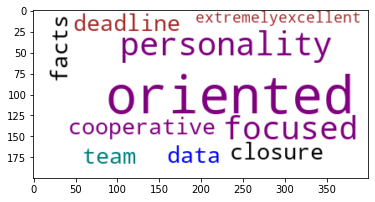

In [ ]:
from wordcloud import WordCloud
np.random.seed(0)

def cluster_to_image(df_cluster, max_words=10, tfidf_matrix=tfidf_matrix,
                     vectorizer=vectorizer):
    indices = df_cluster.Index.values
    summed_tfidf = np.asarray(tfidf_matrix[indices].sum(axis=0))[0]
    data = {'Word': vectorizer.get_feature_names(),'Summed TFIDF': summed_tfidf}
    df_ranked_words = pd.DataFrame(data).sort_values('Summed TFIDF', ascending=False)
    words_to_score = {word: score
                     for word, score in df_ranked_words[:max_words].values
                     if score != 0}
    cloud_generator = WordCloud(background_color='white',
                                color_func=_color_func,
                                random_state=1)
    wordcloud_image = cloud_generator.fit_words(words_to_score)
    return wordcloud_image

def _color_func(*args, **kwargs):
    return np.random.choice(['black', 'blue', 'teal', 'purple', 'brown'])

wordcloud_image = cluster_to_image(cluster_groups[0])
plt.imshow(wordcloud_image, interpolation="bilinear")
plt.show()

In [ ]:
np.random.seed(1)
def print_cluster_sample(cluster_id):
    df_cluster = cluster_groups[cluster_id]
    for bullet in np.random.choice(df_cluster.Bullet.values, 5,
                                   replace=False):
        print(bullet)

print_cluster_sample(0)

Data-oriented personality
Detail-oriented
Detail-oriented — quality and precision-focused
Should be extremelyExcellent facts and data oriented
Data oriented personality


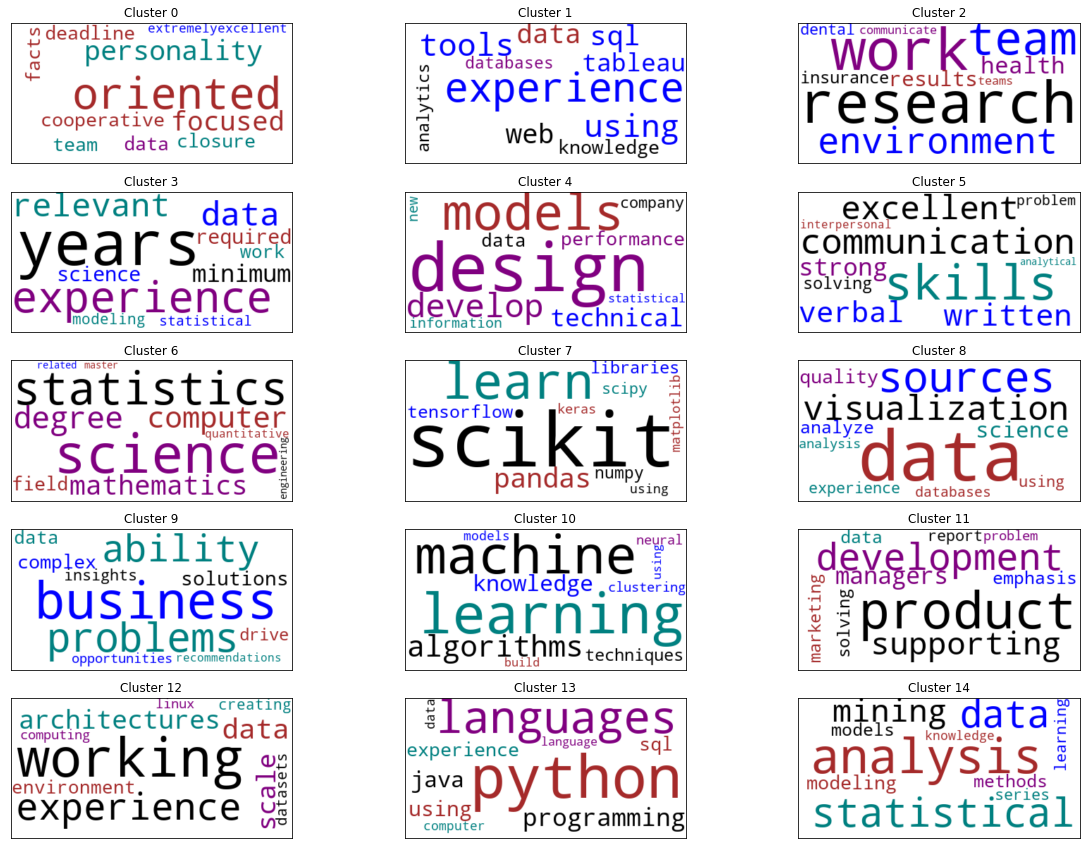

In [ ]:
def plot_wordcloud_grid(cluster_groups, num_rows=5, num_columns=3,
                        **kwargs):
    figure, axes = plt.subplots(num_rows, num_columns, figsize=(20, 15))
    cluster_groups_copy = cluster_groups[:]
    for r in range(num_rows):
        for c in range(num_columns):
            if not cluster_groups_copy:
                break

            df_cluster = cluster_groups_copy.pop(0)
            wordcloud_image = cluster_to_image(df_cluster, **kwargs)
            ax = axes[r][c]
            ax.imshow(wordcloud_image,
            interpolation="bilinear")
            ax.set_title(f"Cluster {df_cluster.Cluster.iloc[0]}")
            ax.set_xticks([])
            ax.set_yticks([])

plot_wordcloud_grid(cluster_groups)
plt.show()

In [ ]:
np.random.seed(1)
print_cluster_sample(7)

Experience using one or more of the following software packages: scikit-learn, numpy, pandas, jupyter, matplotlib, scipy, nltk, spacy, keras, tensorflow
Using one or more of the following software packages: scikit-learn, numpy, pandas, jupyter, matplotlib, scipy, nltk, spacy, keras, tensorflow
Experience with machine learning libraries and platforms, like Scikit-learn and Tensorflow
Proficiency in incorporating the use of external proprietary and open-source libraries such as, but not limited to, Pandas, Scikit- learn, Matplotlib, Seaborn, GDAL, GeoPandas, and ArcPy
Experience using ML libraries, such as scikit-learn, caret, mlr, mllib


In [ ]:
def compute_bullet_similarity(bullet_texts):
    bullet_vectorizer = TfidfVectorizer(stop_words='english')
    matrix = bullet_vectorizer.fit_transform(bullet_texts + [resume])
    matrix = matrix.toarray()
    return matrix[:-1] @ matrix[-1]

bullet_cosine_similarities = compute_bullet_similarity(total_bullets)

In [ ]:
def compute_mean_similarity(df_cluster):
    indices = df_cluster.Index.values
    return bullet_cosine_similarities[indices].mean()

tech_mean = compute_mean_similarity(cluster_groups[13])
soft_mean =  compute_mean_similarity(cluster_groups[6])
print(f"Technical cluster 13 has a mean similarity of {tech_mean:.3f}")
print(f"Soft-skill cluster 6 has a mean similarity of {soft_mean:.3f}")

Technical cluster 13 has a mean similarity of 0.072
Soft-skill cluster 6 has a mean similarity of 0.007


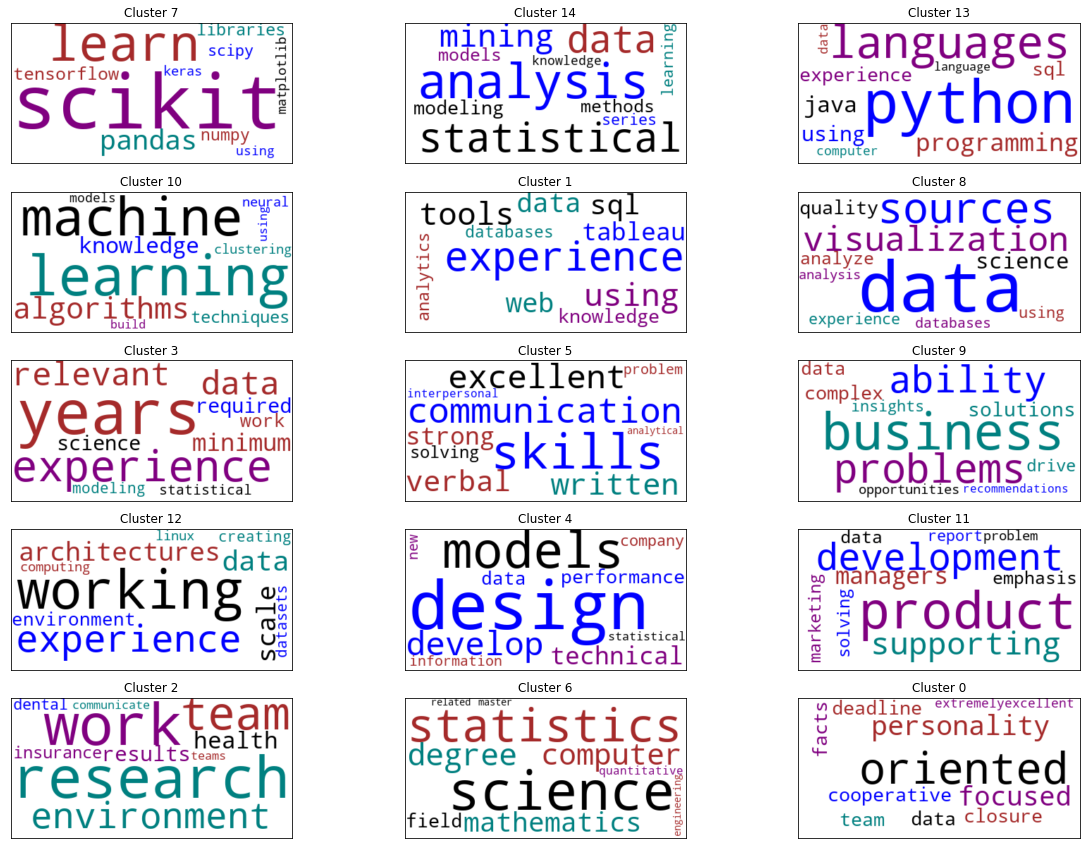

In [ ]:
def sort_cluster_groups(cluster_groups):
    mean_similarities = [compute_mean_similarity(df_cluster)
                         for df_cluster in cluster_groups]

    sorted_indices = sorted(range(len(cluster_groups)),
                            key=lambda i: mean_similarities[i],
                            reverse=True)
    return [cluster_groups[i] for i in sorted_indices]

sorted_cluster_groups = sort_cluster_groups(cluster_groups)
plot_wordcloud_grid(sorted_cluster_groups)
plt.show()

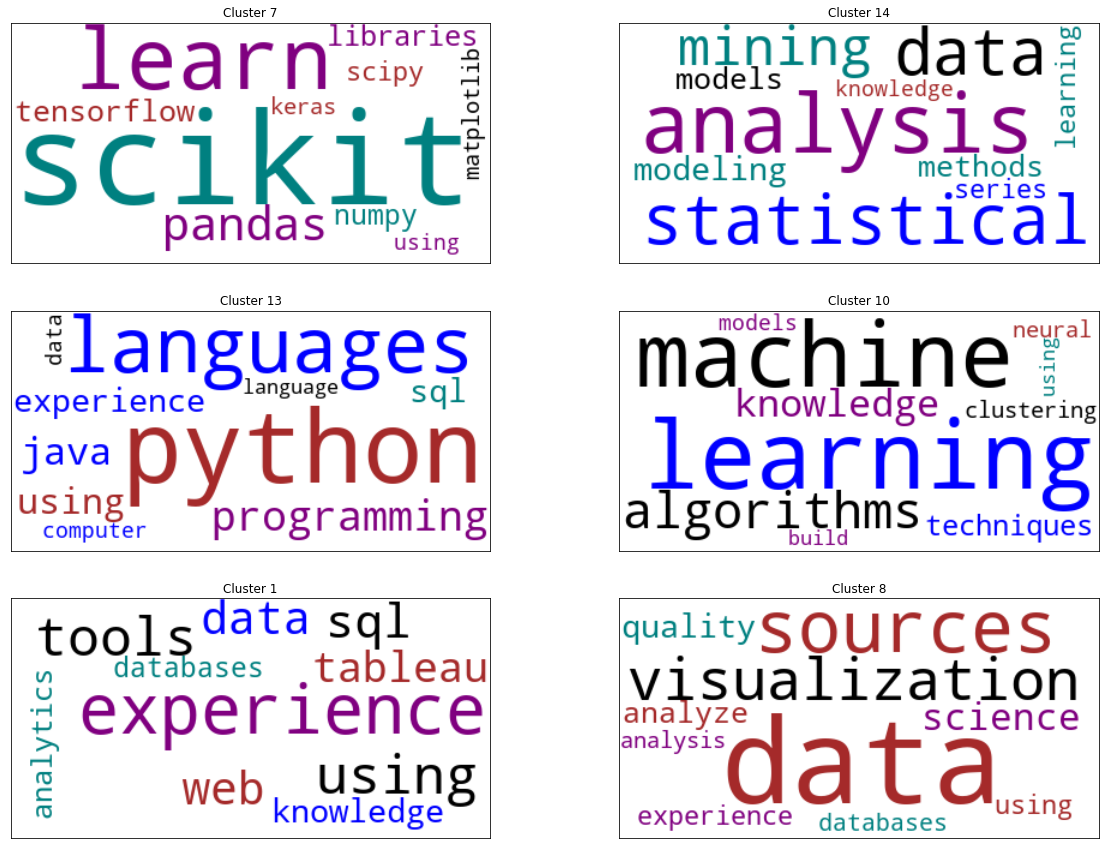

In [ ]:
plot_wordcloud_grid(sorted_cluster_groups[:6], num_rows=3, num_columns=2)
plt.show()

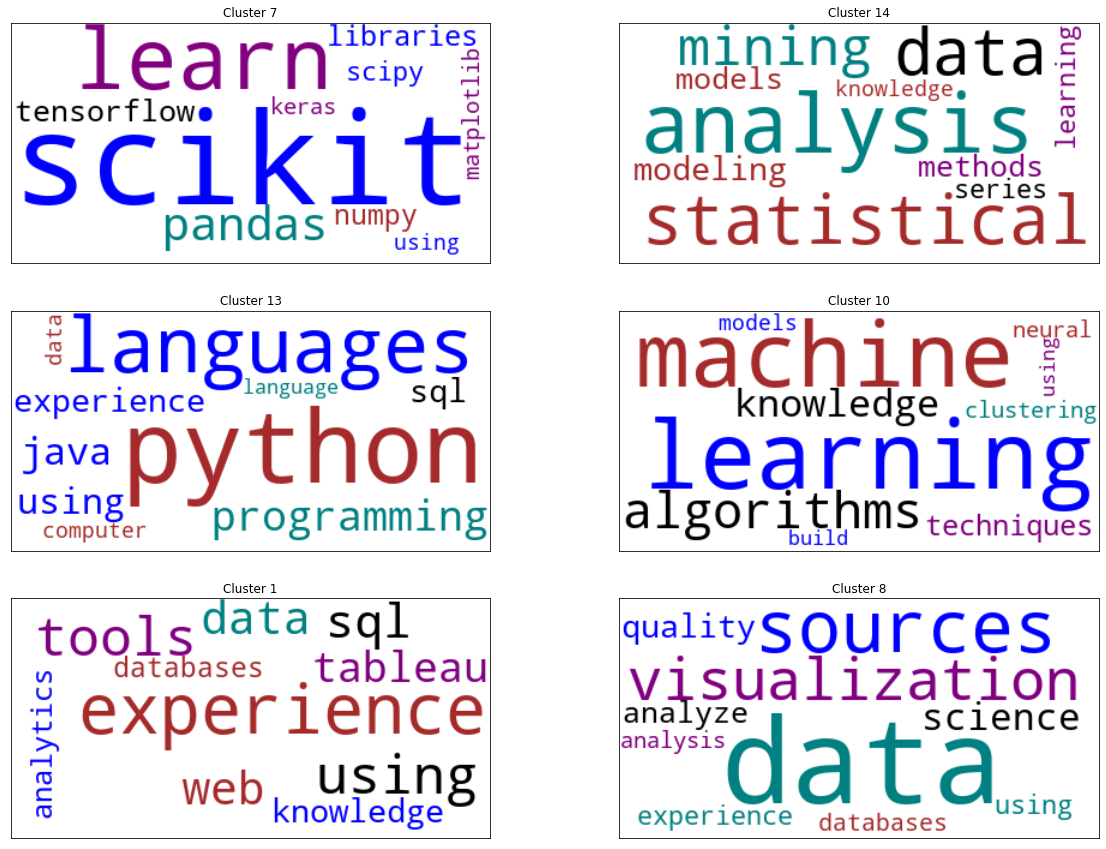

In [ ]:
plot_wordcloud_grid(sorted_cluster_groups[:6], num_rows=3, num_columns=2)
plt.show()

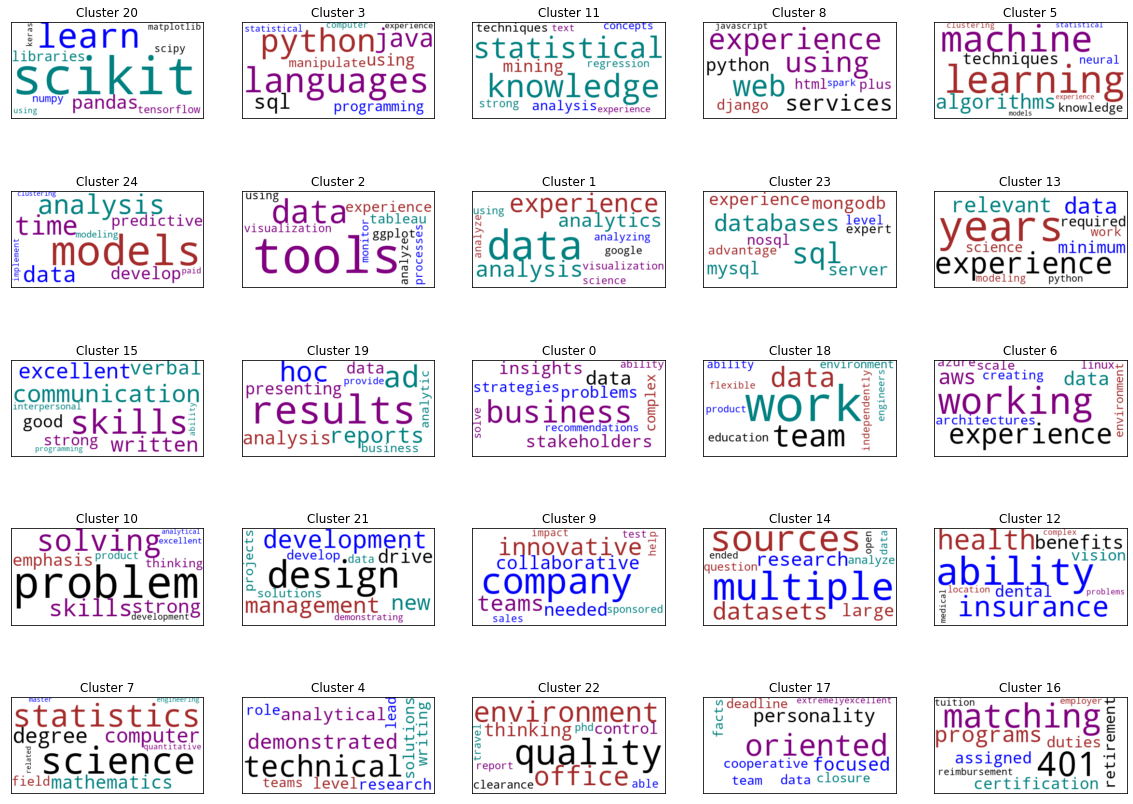

In [ ]:
np.random.seed(0)
cluster_groups = compute_cluster_groups(shrunk_norm_matrix, k=25)
sorted_cluster_groups = sort_cluster_groups(cluster_groups)
plot_wordcloud_grid(sorted_cluster_groups, num_rows=5, num_columns=5)
plt.show()

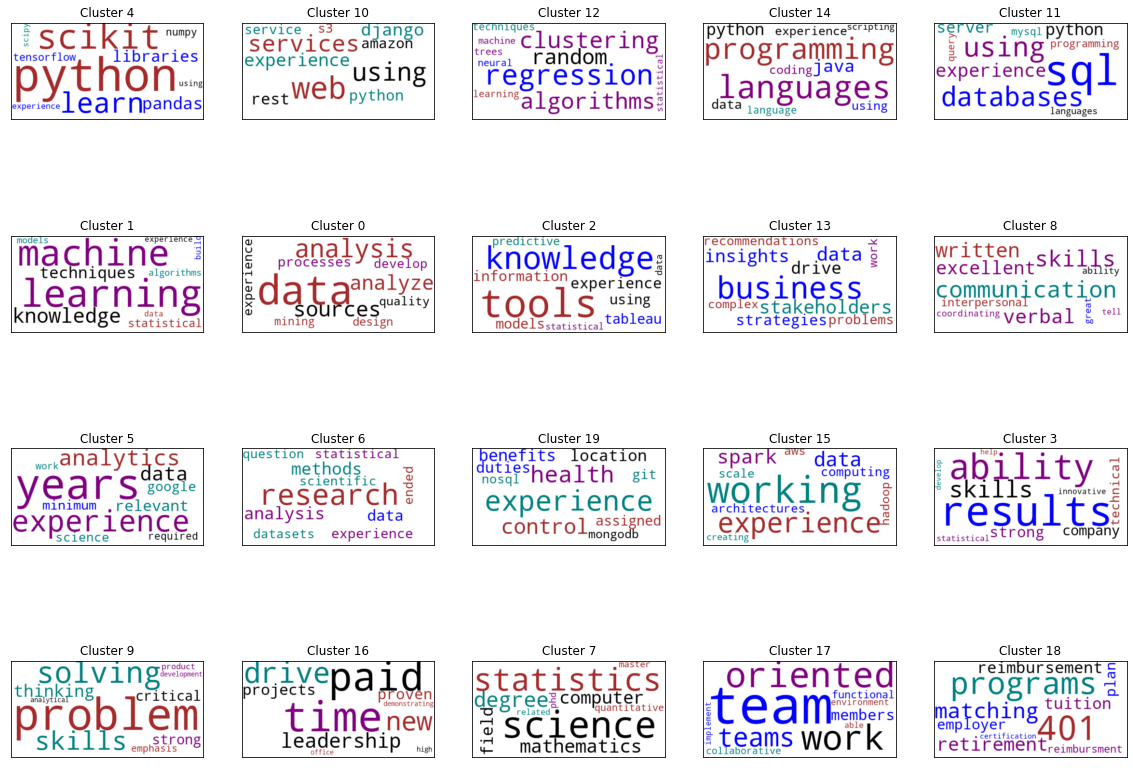

In [ ]:
np.random.seed(0)
cluster_groups = compute_cluster_groups(shrunk_norm_matrix, k=20)
sorted_cluster_groups = sort_cluster_groups(cluster_groups)
plot_wordcloud_grid(sorted_cluster_groups, num_rows=4, num_columns=5)
plt.show()

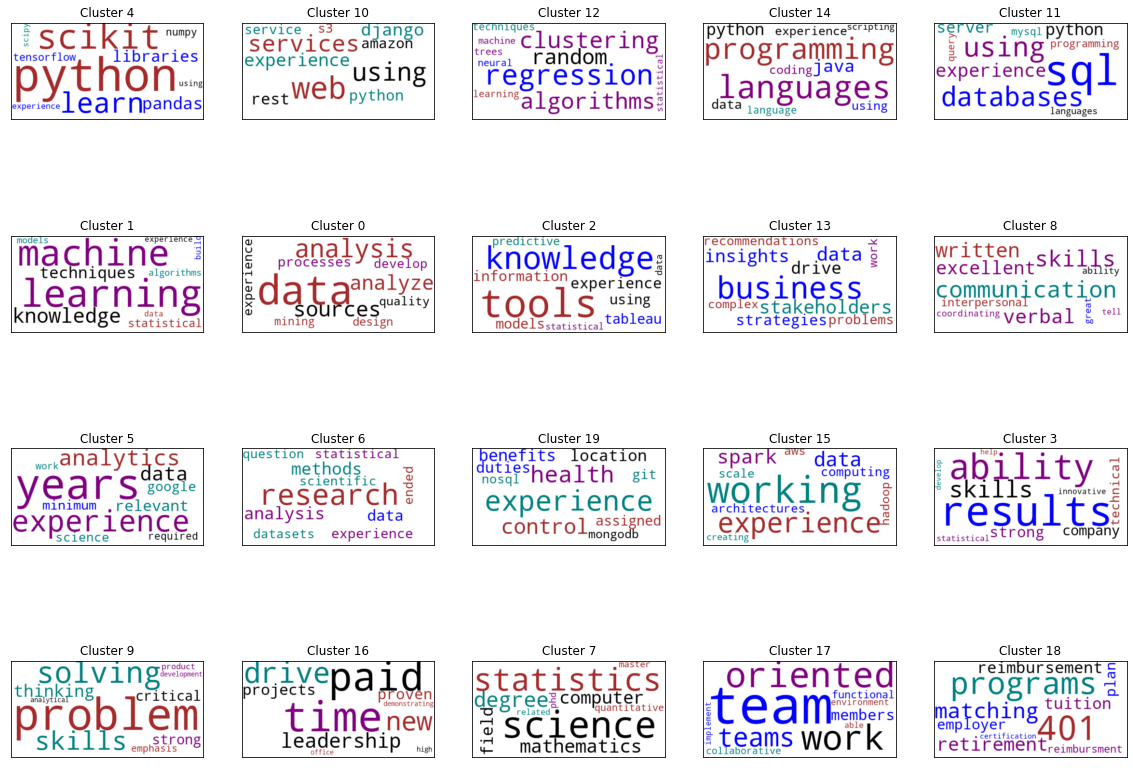

In [ ]:
np.random.seed(0)
cluster_groups = compute_cluster_groups(shrunk_norm_matrix, k=20)
sorted_cluster_groups = sort_cluster_groups(cluster_groups)
plot_wordcloud_grid(sorted_cluster_groups, num_rows=4, num_columns=5)
plt.show()

**Analysing 700 postings**

In [ ]:
np.random.seed(0)
total_bullets_700 = set()
for bullets in sorted_df_jobs[:700].Bullets:
    total_bullets_700.update([bullet.strip()
                              for bullet in bullets])

total_bullets_700 = sorted(total_bullets_700)
vectorizer_700 = TfidfVectorizer(stop_words='english')
tfidf_matrix_700 = vectorizer_700.fit_transform(total_bullets_700)
shrunk_norm_matrix_700 = shrink_matrix(tfidf_matrix_700)
print(f"We've vectorized {shrunk_norm_matrix_700.shape[0]} bullets")

We've vectorized 10194 bullets


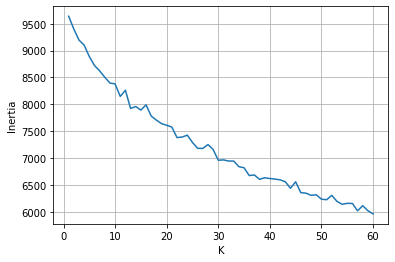

In [ ]:
np.random.seed(0)
generate_elbow_plot(shrunk_norm_matrix_700)
plt.show()

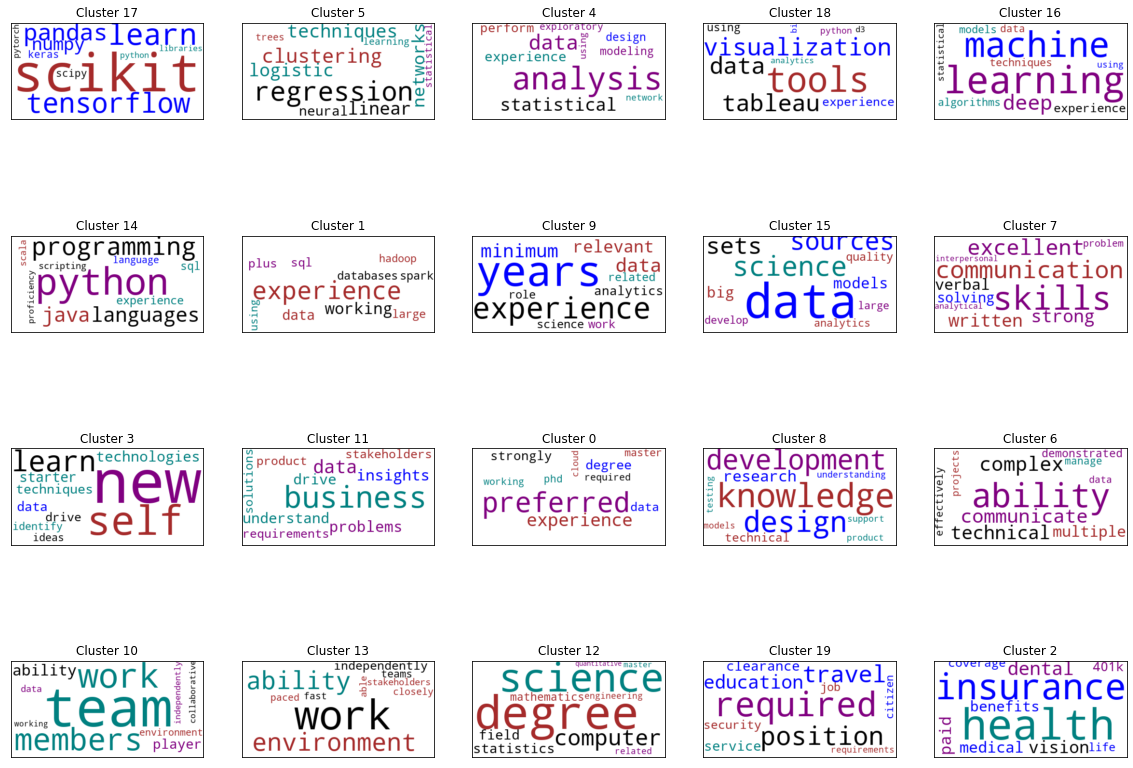

In [ ]:
np.random.seed(0)
cluster_groups_700 = compute_cluster_groups(shrunk_norm_matrix_700, k=20,
                                            bullets=total_bullets_700)
bullet_cosine_similarities = compute_bullet_similarity(total_bullets_700)
sorted_cluster_groups_700 = sort_cluster_groups(cluster_groups_700)
plot_wordcloud_grid(sorted_cluster_groups_700, num_rows=4, num_columns=5,
                    vectorizer=vectorizer_700,
                    tfidf_matrix=tfidf_matrix_700)

---

In [ ]:
!pip install -q watermark
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d

Author: Sparsh A.

Last updated: 2021-11-21 07:11:49

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

numpy     : 1.19.5
IPython   : 5.5.0
re        : 2.2.1
pandas    : 1.1.5
matplotlib: 3.2.2



---